In [16]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures


import requests
from bs4 import BeautifulSoup


In [17]:
min_year = 1920
max_year = 2010
degr = 3
username = "spicymcspice"

In [18]:
df = pd.read_csv("watched.csv")

In [19]:
# five number summary of df[Year]
print(df["Year"].describe())

count    1293.000000
mean     1999.541377
std        21.081425
min      1921.000000
25%      1988.000000
50%      2007.000000
75%      2015.000000
max      2024.000000
Name: Year, dtype: float64


In [20]:
# only contain rows where the year is between min and max year

df = df[(df["Year"] >= min_year) & (df["Year"] <= max_year)]

In [21]:
year_frequency = df['Year'].value_counts().reset_index()
year_frequency.columns = ['Year', 'Frequency']

# If there is a value missing from the range 1928 to 2010, enter it with 1e-10 frequency
missing_years = [{'Year': i, 'Frequency': 0} for i in range(min_year, max_year) if i not in year_frequency['Year'].values]
print(missing_years)
missing_years_df = pd.DataFrame(missing_years)
year_frequency = pd.concat([year_frequency, missing_years_df]).sort_values('Year').reset_index(drop=True)

# Separate the features and the target variable
X = year_frequency['Year'].values.reshape(-1, 1)
y = year_frequency['Frequency'].values

print(year_frequency)

[{'Year': 1920, 'Frequency': 0}, {'Year': 1923, 'Frequency': 0}, {'Year': 1926, 'Frequency': 0}, {'Year': 1929, 'Frequency': 0}, {'Year': 1930, 'Frequency': 0}]
    Year  Frequency
0   1920          0
1   1921          1
2   1922          1
3   1923          0
4   1924          1
..   ...        ...
86  2006         26
87  2007         27
88  2008         28
89  2009         34
90  2010         32

[91 rows x 2 columns]


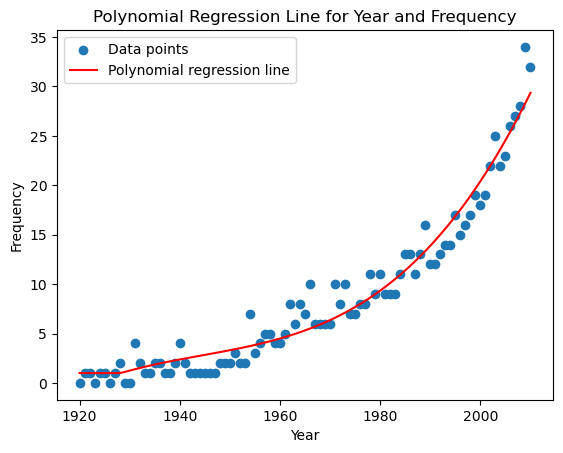

In [22]:
poly = PolynomialFeatures(degree=degr)
X_poly = poly.fit_transform(X)
model = LinearRegression()
model.fit(X_poly, y)
regression_line = model.predict(X_poly)
# if the prediction is <=1, set it to 1
regression_line = np.where(regression_line <= 1, 1, regression_line)
plt.scatter(year_frequency['Year'], year_frequency['Frequency'], label='Data points')
plt.plot(year_frequency['Year'], regression_line, color='red', label='Polynomial regression line')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Polynomial Regression Line for Year and Frequency')
plt.legend()
plt.show()

In [23]:
predictions = regression_line
results_df = year_frequency.copy()
results_df['Exponential_Predictions'] = predictions
results_df['Residuals'] = results_df['Frequency'] - results_df['Exponential_Predictions']

results_df.head()

,Year,Frequency,Exponential_Predictions,Residuals
0,1920,0,1.0,-1.0
1,1921,1,1.0,0.0
2,1922,1,1.0,0.0
3,1923,0,1.0,-1.0
4,1924,1,1.0,0.0


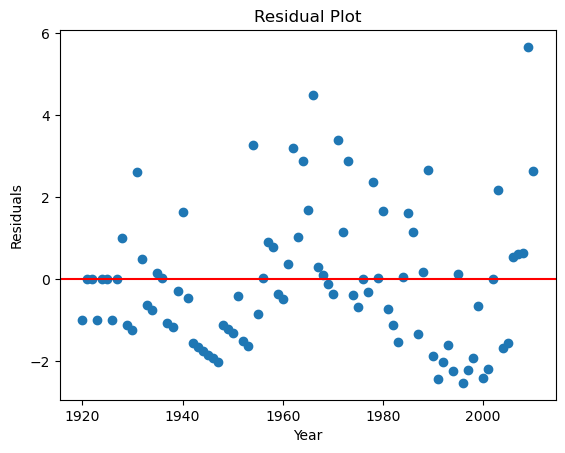

In [24]:
# residual plot
plt.scatter(results_df['Year'], results_df['Residuals'])
plt.axhline(y=0, color='red')
plt.xlabel('Year')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

In [25]:
equation = f'y = {model.intercept_:.4f}'
for i, coef in enumerate(model.coef_):
    equation += f' + {coef:.6f}x^{i+1}'
print(equation)

y = -534597.9895 + 0.000000x^1 + 824.660824x^2 + -0.424080x^3 + 0.000073x^4


In [26]:
results_df.to_csv('polyreg.csv', index=False)

print("Exported the exponential regression results to 'polyreg.csv'")

Exported the exponential regression results to 'polyreg.csv'


In [27]:
print(results_df.sort_values(by='Residuals').head(16))

    Year  Frequency  Exponential_Predictions  Residuals
76  1996         15                17.527019  -2.527019
71  1991         12                14.433301  -2.433301
80  2000         18                20.404772  -2.404772
74  1994         14                16.225020  -2.225020
77  1997         16                18.211584  -2.211584
81  2001         19                21.183787  -2.183787
27  1947          1                 3.023000  -2.023000
72  1992         13                15.009618  -2.009618
26  1946          1                 2.930173  -1.930173
78  1998         17                18.919107  -1.919107
70  1990         12                13.877325  -1.877325
25  1945          1                 2.838057  -1.838057
24  1944          1                 2.746216  -1.746216
84  2004         22                23.670795  -1.670795
23  1943          1                 2.654215  -1.654215
33  1953          2                 3.619327  -1.619327


In [28]:
print('Mean Squared Error:', mean_squared_error(results_df['Frequency'], results_df['Exponential_Predictions']))
print('Mean Absolute Error:', mean_absolute_error(results_df['Frequency'], results_df['Exponential_Predictions']))

Mean Squared Error: 2.743274163652947
Mean Absolute Error: 1.2713063933942876


In [29]:
min_resid_yr = results_df.loc[results_df['Residuals'].idxmin(), 'Year']
print(f"The year with the lowest negative residual is {min_resid_yr}")
url = f'https://letterboxd.com/{username}/watchlist/year/{min_resid_yr}/by/popular/'


The year with the lowest negative residual is 1996


In [30]:

response = requests.get(url)

if response.status_code == 200:
    soup = BeautifulSoup(response.text, 'html.parser')
    # print(soup.prettify())
    ul_el = soup.find('ul', class_='poster-list')
    first_movie = ul_el.find('li')
    img = first_movie.find('img')
    img_tag = img['alt']
    print(f"The most popular movie in {min_resid_yr} from your watchlist is {img_tag}")



The most popular movie in 1996 from your watchlist is Crash
